# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Использованы данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

**Содержание**<a id='toc0_'></a>    
- 1. [Подготовка данных](#toc1_)    
- 2. [Анализ данных](#toc2_)    
- 3. [Модель](#toc3_)    
  - 3.1. [Решающее дерево](#toc3_1_)    
  - 3.2. [Случайный лес](#toc3_2_)    
  - 3.3. [Тестирование лучшей модели](#toc3_3_)    
- 4. [Итоговый вывод](#toc4_)    
- 5. [Чек-лист готовности проекта](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Подготовка данных](#toc0_)

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import make_scorer

Импортируем и изучим данные.

In [2]:
raw_train_data = pd.read_csv('gold_recovery_train_new.csv', index_col='date')
raw_test_data = pd.read_csv('gold_recovery_test_new.csv', index_col='date')
raw_full_data = pd.read_csv('gold_recovery_full_new.csv', index_col='date')

In [3]:
raw_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

In [4]:
raw_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

In [5]:
raw_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

Для начала проверим, правильно ли найдена эффективность обогащения `rougher.output.recovery`. Напишем функцию для её вычисления и найдём МАЕ между расчётами и значением признака.

In [6]:
def recovery(c, f, t):
    rec = 100 * c * (f - t) / (f * (c - t))
    return rec
    
def rougher_output_recovery(row):
    rec = recovery(c=row['rougher.output.concentrate_au'],
                   f=row['rougher.input.feed_au'],
                   t=row['rougher.output.tail_au'])
    return rec

In [7]:
mae(raw_train_data['rougher.output.recovery'],
    raw_train_data.apply(rougher_output_recovery, axis=1))

1.1498046842860452e-14

Рассматриваемая величина посчитана верно, среднее отклонение значительно меньше значений самой величины.

Рассмотрим признаки, общие для всех выборок, а также недоступные в тестовой выборке.

In [8]:
# Общие для всех выборок признаки
features_list = sorted(list(
    set(raw_train_data.columns).intersection(set(raw_test_data))))
features_list

['primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rough

In [9]:
# Признаки, недоступные в тестовой выборке
sorted(list(set(raw_train_data.columns) - set(raw_test_data)))

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке недоступны выходные параметры продукта и расчётные характеристики. Все остальные данные присутствуют во всех выборках.

Интерес представляют целевые признаки `rougher.output.recovery` и `final.output.recovery`. Отделим их от остальных признаков.

In [10]:
features_train = raw_train_data[features_list].copy()
target_train = raw_train_data[['rougher.output.recovery', 'final.output.recovery']].copy()

Учитывая, что одни и те же показатели не сильно изменяются в течение небольшого промежутка времени, а пропусков в данных немного, заполним их ближайшими ранними значениями.

In [11]:
features_train.fillna(method='ffill', inplace=True)

Найдём значения целевых признаков для тестовой выборки, взяв их из исходных данных.

In [12]:
features_test = raw_test_data.fillna(method='ffill')[features_list]
target_test = raw_full_data.loc[raw_test_data.index, ['rougher.output.recovery', 'final.output.recovery']]

Проверим размеры полученных датасетов.

In [13]:
print(features_train.shape, target_train.shape)

(14149, 52) (14149, 2)


**Вывод по разделу 1:**
- Обучающая выборка содержит 87 признаков, среди которых 52 выбраны для обучения модели, ещё 2 - целевые, остальные (выходные параметры продукта и расчётные характеристики) отсутствуют в тестовой выборке.
- Эффективность обогащения в исходных данных рассчитана верно.
- Небольшое количество пропусков заполнено предыдущими по времени значениями.
- Обучающая выборка разбита на валидационную и непосредственно обучающую, а также отмасштабирована.

## 2. <a id='toc2_'></a>[Анализ данных](#toc0_)

Для начала исследуем данные на мультиколлинеарность. Так как их довольно много, построим хитмэп.

<AxesSubplot: >

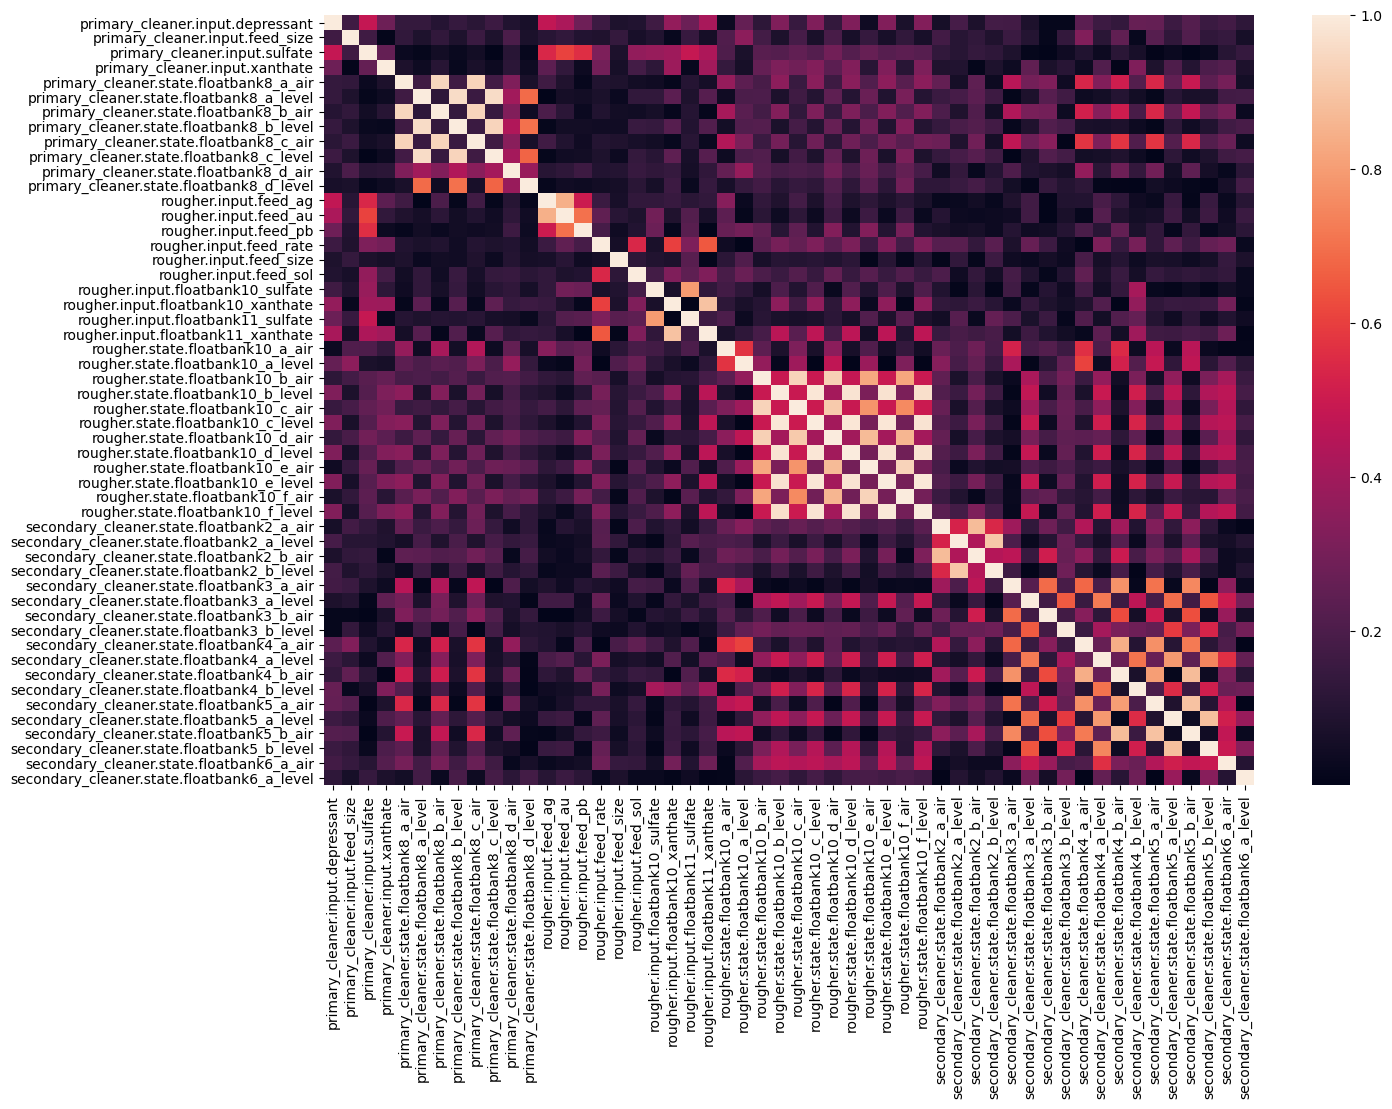

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(features_train.corr().abs())

Корреляция между признаками крайне слабая.
<br>Некоторые признаки из группы `rougher.state.floatbank` между собой коррелируют сильно - коэф. корреляции > 0.6 (то же с `rougher.input.feed` и `secondary_cleaner.state.floatbank`). 

Изучим как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки, рассмотрев их распределения.

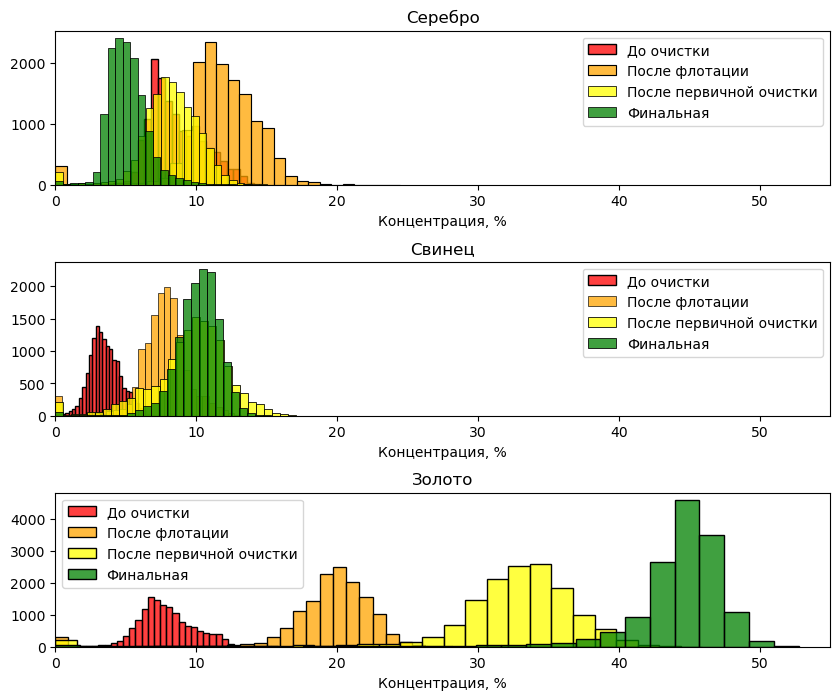

In [15]:
stages = ['rougher.input.feed_', 'rougher.output.concentrate_',\
          'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
stages_names = ['До очистки', 'После флотации', 'После первичной очистки', 'Финальная']
metalls = ['ag', 'pb', 'au']
metalls_names = ['Серебро', 'Свинец', 'Золото']
colors = ['red', 'orange', 'yellow', 'green']

fig, axes = plt.subplots(nrows=3, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)

for ax, metall, metall_name in zip(axes, metalls, metalls_names):
    for stage, stage_name, color in zip(stages, stages_names, colors):
        sns.histplot(raw_train_data[stage + metall],
                     bins=30, label=stage_name, color=color, ax=ax)\
            .set(ylabel='', xlabel='Концентрация, %', xlim=(0, 55))
    ax.set(title=metall_name)
    ax.legend()

Концентрация золота в сырьё увеличивается на каждом этапе очистки, других металлов - почти не изменяется (около 10%).

Сравним теперь распределения размеров гранул сырья на обучающей и тестовой выборках.

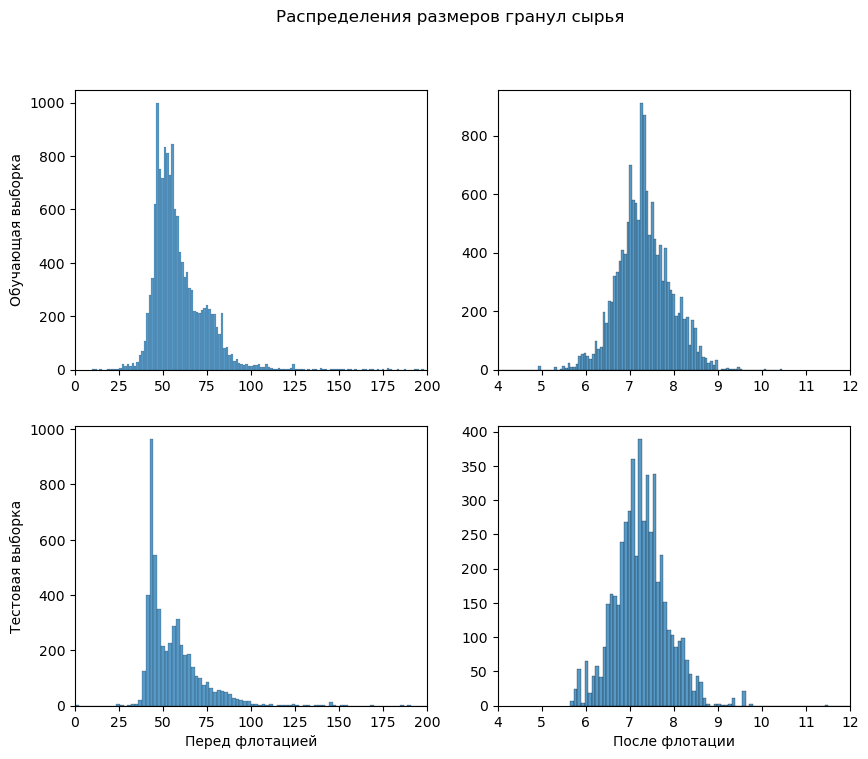

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
fig.suptitle('Распределения размеров гранул сырья')

sns.histplot(x=features_train['rougher.input.feed_size'], ax=ax[0][0])\
            .set(xlabel='', ylabel='Обучающая выборка', xlim=(0, 200))

sns.histplot(x=features_test['rougher.input.feed_size'], ax=ax[1][0])\
            .set(xlabel='Перед флотацией', ylabel='Тестовая выборка', xlim=(0, 200))

sns.histplot(x=features_train['primary_cleaner.input.feed_size'], ax=ax[0][1])\
            .set(ylabel='', xlabel='', xlim=(4, 12))

sns.histplot(x=features_test['primary_cleaner.input.feed_size'], ax=ax[1][1])\
            .set(ylabel='', xlabel='После флотации', xlim=(4, 12));

Распределения размеров гранул сырья в обеих выборках практически совпадают.
<br>Это условие выполняется на двух стадиях: до флотации и после неё.

Исследуем концентрацию всех веществ (Au, Ag, Pb, Sol) на разных стадиях: в сырье, в черновом и финальном концентратах. 

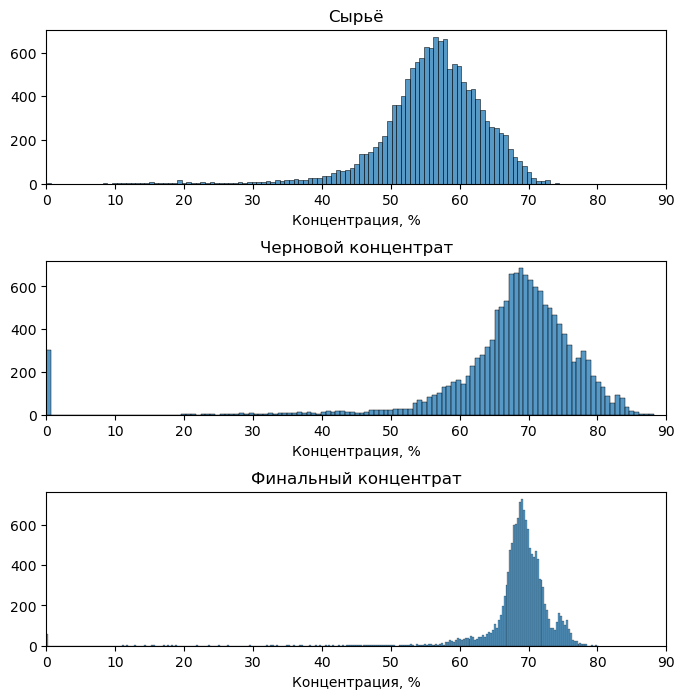

In [17]:
stages = ['rougher.input.feed_', 'rougher.output.concentrate_', 'final.output.concentrate_']
stages_names = ['Сырьё', 'Черновой концентрат', 'Финальный концентрат']
substances = metalls + ['sol']

fig, axes = plt.subplots(nrows=3, figsize=(8, 8))
plt.subplots_adjust(hspace=0.5)

for stage, stage_name, ax in zip(stages, stages_names, axes):
    cols = [stage + substance for substance in substances]
    
    sns.histplot(raw_train_data[cols].sum(axis=1), ax=ax)\
        .set(xlim=(0, 90), xlabel='Концентрация, %', ylabel='')
    
    ax.set(title=stage_name)

На стадии флотации суммарная концентрация обозначенных веществ повышается примерно на 10-15%. После очистки разброс данной величины уменьшается при неизменном среднем, это происходит (скорее всего) из-за увеличения концентрации золота и удаления примесей.

 Необходимо убрать из обучающей выборки выбросы - строки, где суммарная концентрация меньше 10%.

In [18]:
raw_train_data.shape, features_train.shape

((14149, 86), (14149, 52))

In [19]:
warnings.simplefilter("ignore", UserWarning)

for stage, stage_name in zip(stages, stages_names):
    cols = [stage + substance for substance in substances]
    condition = raw_train_data[cols].sum(axis=1) < 10
    print(f'Количество дропнутых строк на этапе {stage_name}:',
          features_train[condition].shape[0])
    features_train.drop(features_train[condition].index, inplace=True)
    target_train.drop(target_train[condition].index, inplace=True)

Количество дропнутых строк на этапе Сырьё: 12
Количество дропнутых строк на этапе Черновой концентрат: 297
Количество дропнутых строк на этапе Финальный концентрат: 59


**Вывод по разделу 2:**
- Корреляция между признаками крайне слабая.
- Концентрация золота в сырьё увеличивается на каждом этапе очистки, других металлов - почти не изменяется (около 10%).
- Распределения размеров гранул сырья в обучающей и тестовой выборках практически совпадают.
- На стадии флотации суммарная концентрация веществ (Ag, Pb, Sol) повышается примерно на 10-15%. После очистки разброс данной величины уменьшается при неизменном среднем.

## 3. <a id='toc3_'></a>[Модель](#toc0_)

Напишем функцию для вычисления итоговой sMAPE.

In [20]:
def smape(target, predictions):
    denominator = (target.abs() + predictions.abs()) / 2
    result = 100 * ((target - predictions).abs() / denominator).mean()
    return result

def final_smape(target, predictions):
    predictions = pd.DataFrame(predictions, index=target.index, columns=target.columns)
    result = 0.25 * smape(target.iloc[:, 0], predictions.iloc[:, 0]) + 0.75 * smape(target.iloc[:, 1], predictions.iloc[:, 1])
    return result

scorer = make_scorer(final_smape, greater_is_better=False)

Обучим модели решающего дерева и случайного леса, выбрав оптимальные гиперапараметры, и проверим их качество кросс-валидацией.

### 3.1. <a id='toc3_1_'></a>[Решающее дерево](#toc0_)

In [21]:
param_grid = {
    'max_depth': [10, 20, 50, 100],
    'max_features': [None, 2, 3],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 12],
}

decision_tree = DecisionTreeRegressor(random_state=42)

dt_grid = GridSearchCV(estimator = decision_tree, param_grid = param_grid,
                       scoring=scorer, cv = 3, n_jobs = -1, verbose = 1)

In [22]:
%%time
dt_grid.fit(features_train, target_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
CPU times: total: 5.64 s
Wall time: 1min 16s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 50, 100],
                         'max_features': [None, 2, 3],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 12]},
             scoring=make_scorer(final_smape, greater_is_better=False),
             verbose=1)

In [23]:
print('Значение sMAPE, время обучения и время оценки и при различных гиперпараметрах:')
print(pd.DataFrame(dt_grid.cv_results_)[['mean_test_score', 'mean_fit_time', 'mean_score_time']])
print('\nЛучшие гиперпараметры:\n', dt_grid.best_params_)
print('Лучшее значение sMAPE:', -dt_grid.best_score_)

Значение sMAPE, время обучения и время оценки и при различных гиперпараметрах:
     mean_test_score  mean_fit_time  mean_score_time
0         -13.245448       1.271515         0.014169
1         -13.049841       1.278037         0.024317
2         -12.406535       1.300078         0.013179
3         -11.934828       1.200750         0.011143
4         -11.934828       1.172016         0.012079
..               ...            ...              ...
103       -13.303610       0.181619         0.015203
104       -13.177212       0.222831         0.025598
105       -12.657347       0.204841         0.011801
106       -12.657347       0.156652         0.015023
107       -17.320921       0.189567         0.017858

[108 rows x 3 columns]

Лучшие гиперпараметры:
 {'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
Лучшее значение sMAPE: 11.531086250723986


### 3.2. <a id='toc3_2_'></a>[Случайный лес](#toc0_)

У случайного леса больше комбинаций гиперпараметров, поэтому GridSearchCV выполняется долго. Здесь лучше использовать HalvingGridSearchCV.

In [24]:
params = {
    'max_depth' : [8, 10, 12],
    'min_samples_split' : [8, 10],
    'min_samples_leaf' : [12, 15]
}
rf_model = RandomForestRegressor(random_state=42)

rf_grid  = HalvingGridSearchCV(rf_model, params, scoring=scorer,
                               cv=3, verbose=3, n_jobs=-1, max_resources=150, factor=3,
                               resource='n_estimators')

In [26]:
%%time
rf_grid.fit(features_train, target_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 16
max_resources_: 150
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 16
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 4
n_resources: 48
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 144
Fitting 3 folds for each of 2 candidates, totalling 6 fits
CPU times: total: 2min 51s
Wall time: 13min 35s


HalvingGridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                    max_resources=150, n_jobs=-1,
                    param_grid={'max_depth': [8, 10, 12],
                                'min_samples_leaf': [12, 15],
                                'min_samples_split': [8, 10]},
                    resource='n_estimators',
                    scoring=make_scorer(final_smape, greater_is_better=False),
                    verbose=3)

In [27]:
print('Значение sMAPE, время обучения и время оценки и при различных гиперпараметрах:')
print(pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'mean_fit_time', 'mean_score_time']])
print('\nЛучшие гиперпараметры:\n', rf_grid.best_params_)
print('Лучшее значение sMAPE:', -rf_grid.best_score_)

Значение sMAPE, время обучения и время оценки и при различных гиперпараметрах:
    mean_test_score  mean_fit_time  mean_score_time
0        -10.128401      19.846894         0.030049
1        -10.128401      19.801334         0.023569
2        -10.098998      19.144847         0.026176
3        -10.098998      18.254509         0.045728
4        -10.290745      23.897507         0.022614
5        -10.290745      20.154824         0.035601
6        -10.263781      18.439774         0.032238
7        -10.263781      18.613991         0.023273
8        -10.373755      19.796506         0.026597
9        -10.373755      22.806194         0.030254
10       -10.299005      24.108317         0.026014
11       -10.299005      24.726412         0.028599
12       -10.091128      50.373125         0.054393
13       -10.091128      55.971755         0.062276
14       -10.122863      57.651802         0.058952
15       -10.122863      54.981691         0.042886
16       -10.083620     144.249539   

### 3.3. <a id='toc3_3_'></a>[Тестирование лучшей модели](#toc0_)

В качестве лучшей модели выберем случайный лес со следующими гиперпараметрами: *max_depth=8, min_samples_leaf=12, min_samples_split=8*, Число деревьев выберем равным 50, т.к. дальнейшее увеличение их количества не приводит к повышению метрики качества, но затягивает процесс обучения.

Зная гиперпараметры нужной модели, обучим ёё на обучающей и валидационной выборках, и проверим качество на тестовой.

In [29]:
best_model = RandomForestRegressor(max_depth=8, min_samples_leaf=12, min_samples_split=8, n_estimators=50, random_state=42)
best_model.fit(features_train, target_train)

predictions_test = best_model.predict(features_test)

print('sMAPE:', final_smape(target_test, predictions_test))

sMAPE: 9.24575469490349


Значение метрики качества на тестовой выборке = 9.24%.

**Вывод по разделу 3:**
- Написана функция для вычисления итогового *sMAPE*.
- Обучены и проверены модели дерева решений и случайного леса с различными гиперпараметрами.
- Лучшая модель - случайный лес со следующими гиперпараметрами: **max_depth=8, min_samples_leaf=12, min_samples_split=8, n_estimators=50**
- Значение ***sMAPE*, полученное тестовой выборке  = 9.24%**, что даже ниже, чем на валидационной.

## 4. <a id='toc4_'></a>[Итоговый вывод](#toc0_)

- В работе была проведена подготовка данных. Данные вполне адекватны.
- Корреляция между признаками крайне слабая.
- Концентрация золота в сырьё увеличивается на каждом этапе очистки, других металлов - почти не изменяется (около 10%).
- На стадии флотации суммарная концентрация веществ (Ag, Pb, Sol) повышается примерно на 10-15%. После очистки разброс данной величины уменьшается при неизменном среднем.
- Лучшая модель - случайный лес (max_depth=8, min_samples_leaf=12, min_samples_split=8, n_estimators=50).
- На тестовой выборке получено значение метрики ***sMAPE* = 9.24%.**

## 5. <a id='toc5_'></a>[Чек-лист готовности проекта](#toc0_)

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке